There is ztf photometry available. Let's have a look.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
import matplotlib.gridspec as gridspec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [19]:
hdul = fits.open('ztf/ztflc5.fits')

In [20]:
hdul[1].data.names

['oid',
 'expid',
 'hjd',
 'mjd',
 'mag',
 'magerr',
 'catflags',
 'filtercode',
 'ra',
 'dec',
 'chi',
 'sharp',
 'filefracday',
 'field',
 'ccdid',
 'qid',
 'limitmag',
 'magzp',
 'magzprms',
 'clrcoeff',
 'clrcounc',
 'exptime',
 'airmass',
 'programid']

In [21]:
#hdul[1].header

In [22]:
#catflags is the data qualiy.  32768 = cloud
data = hdul[1].data
# data['catflags']

In [23]:
dataq = data[data['catflags'] ==0]
gdata = dataq[dataq['filtercode'] == 'zg']
rdata = dataq[dataq['filtercode'] == 'zr']
idata = dataq[dataq['filtercode'] == 'zi']

17.341698 0.022647597
17.724348 0.033028107
18.046307 0.05004758


(18.2, 17.2)

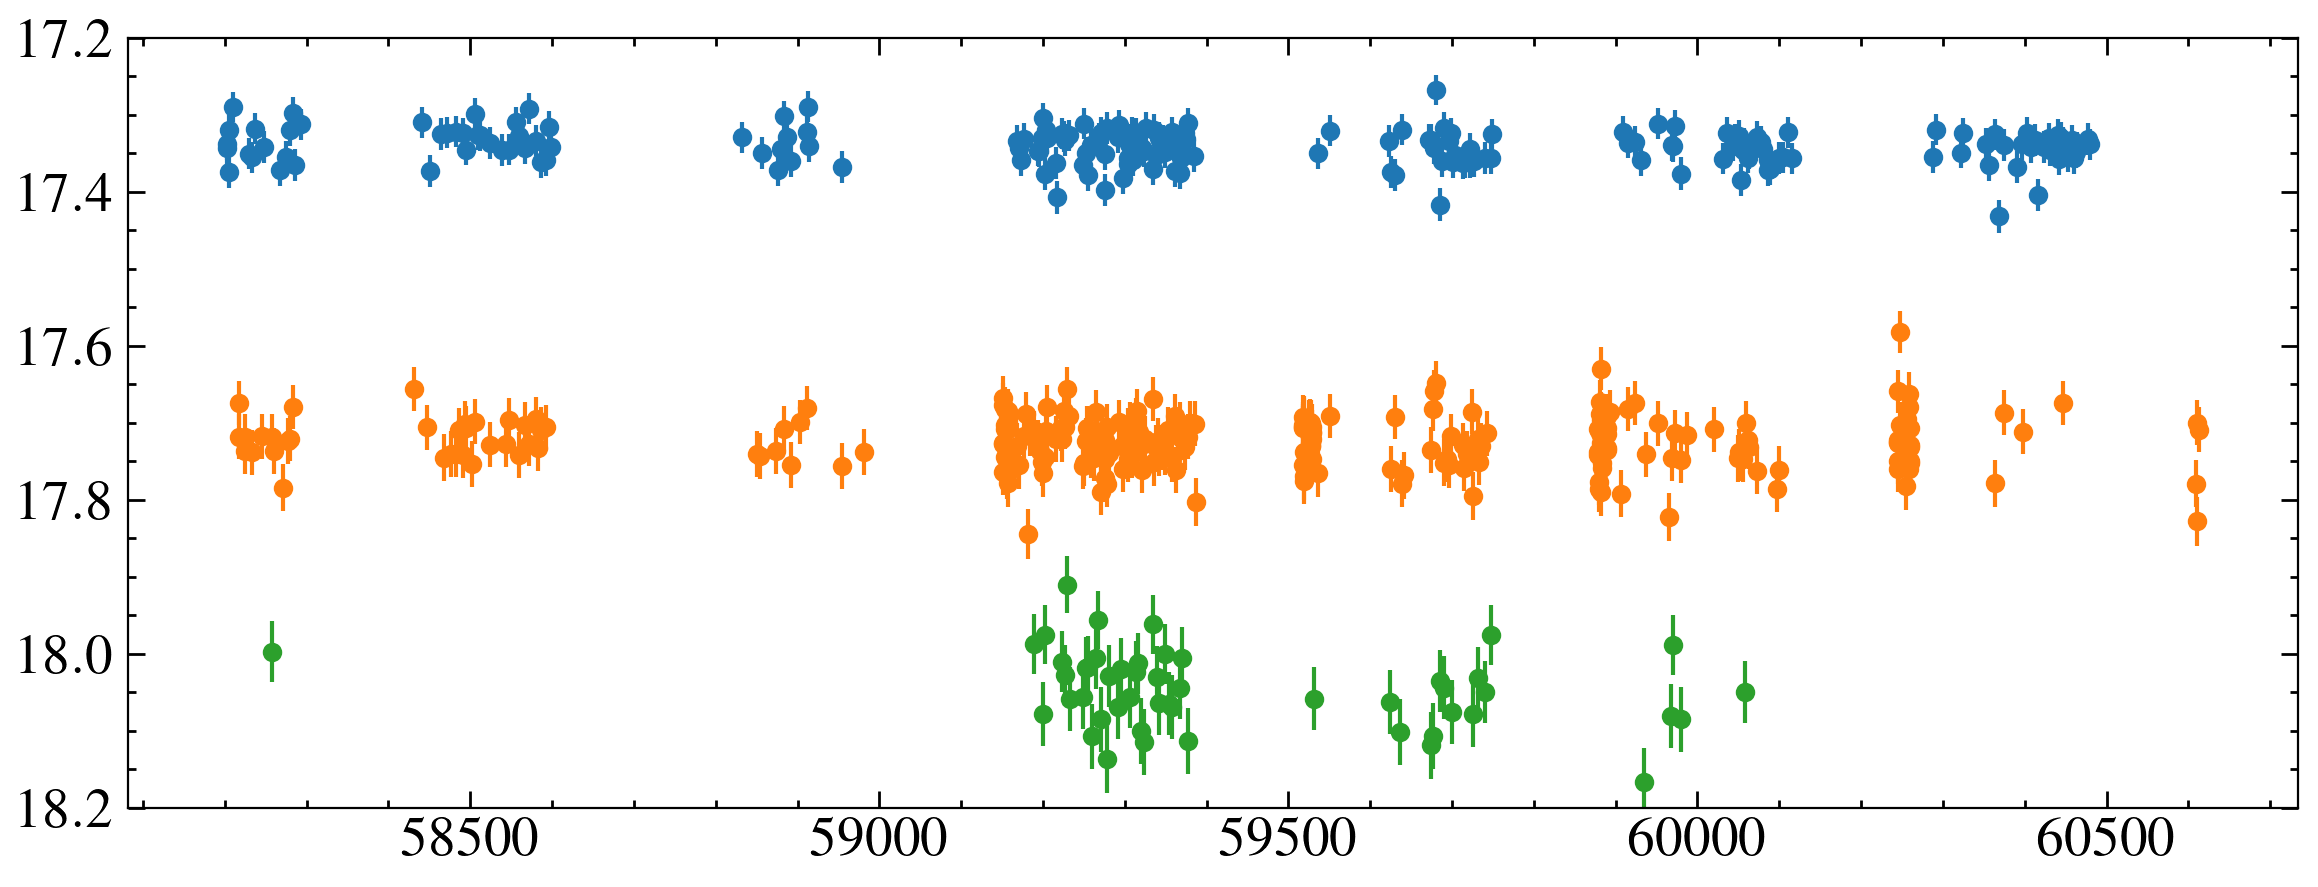

In [24]:
plt.errorbar(gdata['mjd'], gdata['mag'], yerr=gdata['magerr'], marker='o', ls='none')
plt.errorbar(rdata['mjd'], rdata['mag'], yerr=rdata['magerr'], marker='o', ls='none')
plt.errorbar(idata['mjd'], idata['mag'], yerr=idata['magerr'], marker='o', ls='none')
print(np.mean(gdata['mag']), np.std(gdata['mag']))
print(np.mean(rdata['mag']), np.std(rdata['mag']))
print(np.mean(idata['mag']), np.std(idata['mag']))

plt.ylim(18.2, 17.2)

In [25]:
period = 4.223067122779809*u.h

3.494558335902584 h
0.001503566799048735
0.007517833995243675
1.28757279482053 h
0.0018983620742266446
0.009491810371133223
2.9214737702345053 h
0.00656361738919857
0.03281808694599285


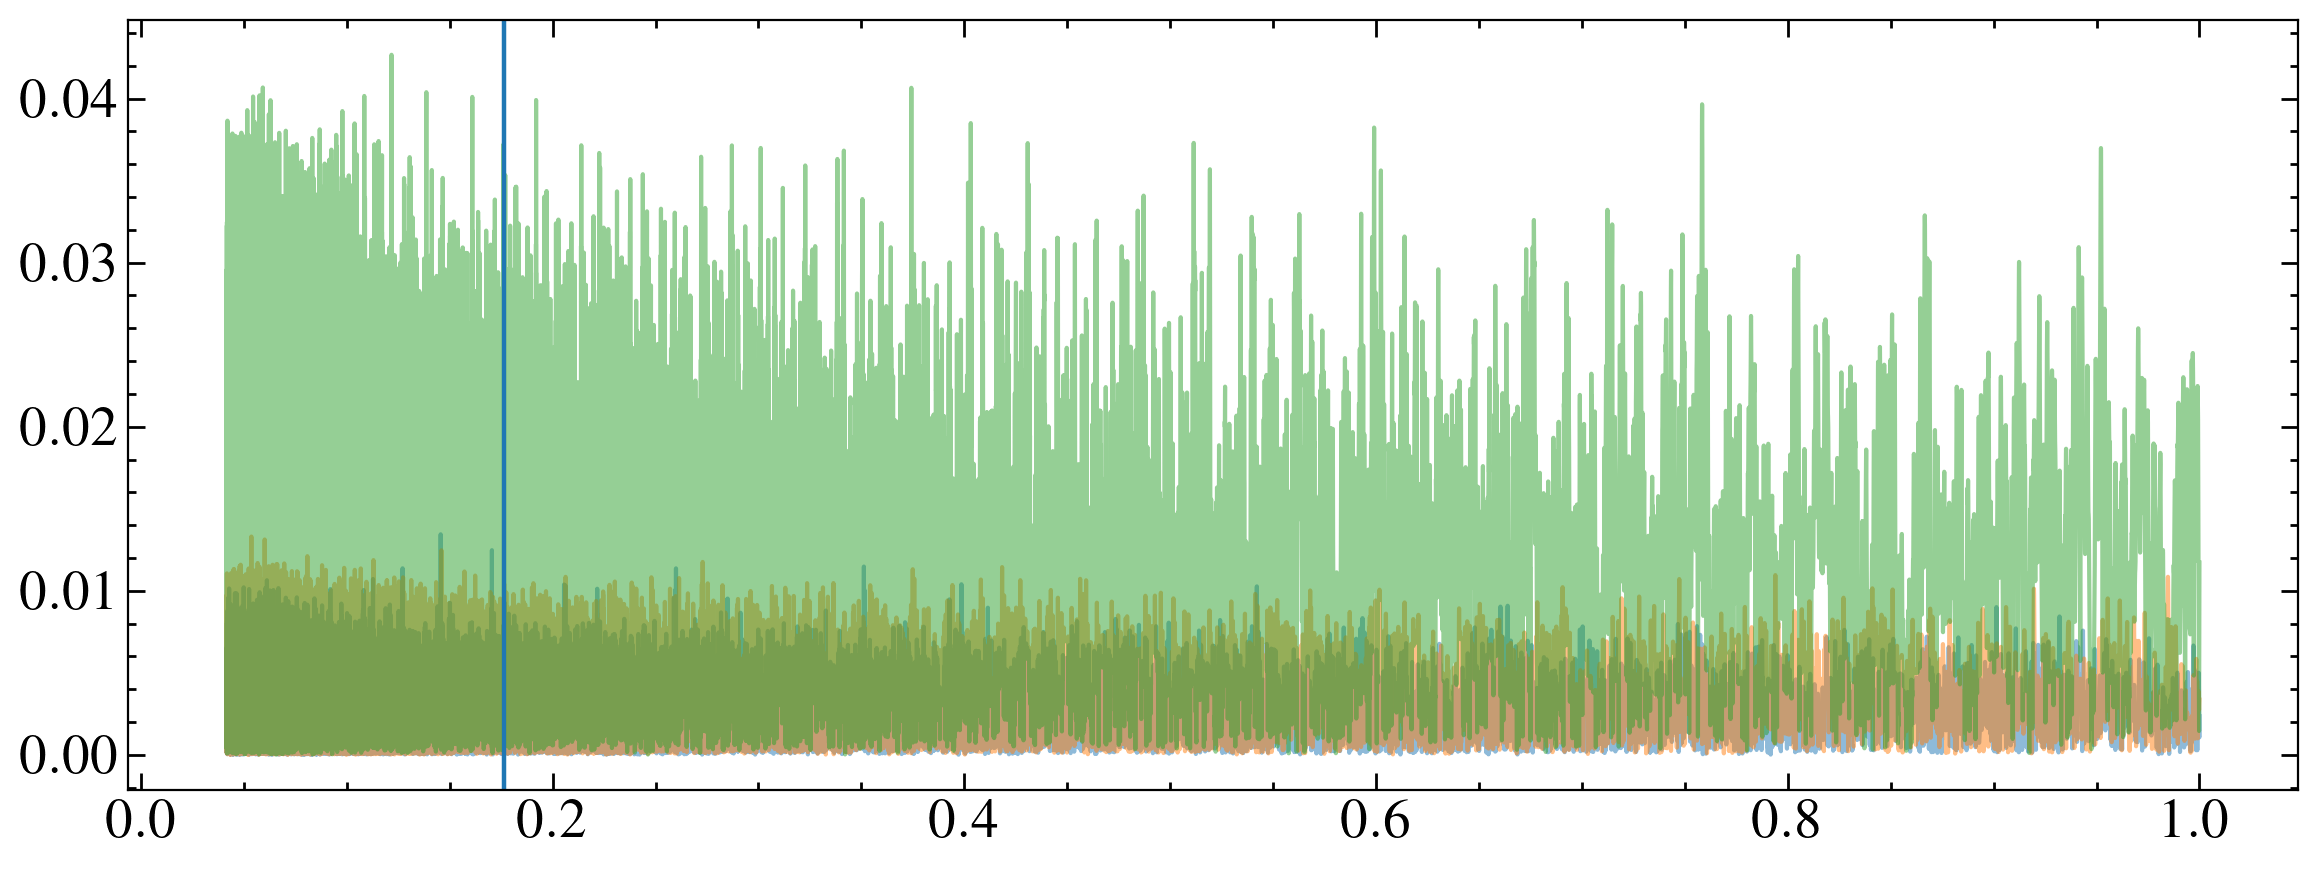

In [38]:
for band in [gdata, rdata, idata]:
    lc = lk.LightCurve(time= band['mjd']*u.d, flux=band['mag'], flux_err=band['magerr'])
    lcfold = lc.fold(period)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=1*u.h, maximum_period=1*u.day)
    plt.plot(pg.period, pg.power, alpha=0.5)
    print(pg.period_at_max_power.to(u.h))
    print(np.std(pg.power))
    print(np.std(pg.power)*5)
    plt.axvline(4.23/24)    

In [27]:
# plt.figure(figsize=(15,6))
# bands = ['$g$', '$r$']
# cols = ['C2', 'C3']
# for i, bandat in enumerate([gdata, rdata]):
#     plt.subplot(121)
#     lc = lk.LightCurve(time= bandat['mjd']*u.d, flux=bandat['mag'], flux_err=bandat['magerr'])
#     lcfold = lc.fold(period)
#     if i == 0:
#         glc = lc
#         glcf = lcfold
#     if i == 1:
#         rlc = lc
#         rlcf = lcfold
#     plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none', label= bands[i], color=cols[i])
#     plt.axhline(np.median(lc.flux), ls='--', c='C1', alpha=0.5)
#     plt.subplot(122)
#     pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.1*u.h, maximum_period=1*u.day)
#     plt.plot(pg.period*24, pg.power, ls='--', c=cols[i])
    
# plt.subplot(121)    
# plt.ylim(17.85, 17.21)
# plt.xlabel('Phase')
# plt.ylabel('AB Magnitude')
# plt.legend()
# plt.subplot(122)
# plt.xscale('log')
# #plt.yscale('log')
# #[plt.axvline(line, ls='--') for line in [-0.03, 0.03]]
# plt.tight_layout()
# #plt.savefig('plots/ztf_folded.pdf')

In [28]:
# #ecclipse duration
# P = period
# a = 0.7*u.Rsun
# R1 = 0.0131*u.Rsun
# R2 = 0.11*u.Rsun

# tdur = P*(2*R1+2*R2)/(2*np.pi*a)
# print(tdur.value*60)

In [29]:
# phase_diff = tdur/period
# print(phase_diff)
# print(np.max(np.diff(glcf.time)))
# print(np.max(np.diff(rlcf.time)))

Is there a colour change?

In [30]:
# print(len(glcf.time), len(rlcf.time))

In [31]:
# from craftroom import resample

In [32]:
# fakegt, fakegf = resample.bintogrid(glc.time, glc.flux, newx=rlc.time)
# fakege = np.full(len(fakegt), np.mean(glc.flux_err))
# plt.errorbar(fakegt, fakegf, yerr=fakege, marker='o', ls='none')
# plt.errorbar(glc.time, glc.flux, yerr=glc.flux_err, marker='o', ls='none')

In [33]:
# gminusr = fakegf - rlc.flux
# gminusr_e = (fakege**2+rlc.flux_err**2)**0.5
# plt.errorbar(fakegt, gminusr, yerr=gminusr_e, marker='o', ls='none')
# plt.show()
# grlc = lk.LightCurve(fakegt[:-1], gminusr[:-1], gminusr_e[:-1])
# grpg = grlc.to_periodogram(oversample_factor=10,minimum_period=0.1*u.h, maximum_period=1*u.day)
# plt.plot(grpg.period, grpg.power)
# plt.axvline(period.to(u.d).value, c='C1', ls='--')

In [34]:
period

<Quantity 4.22306712 h>

Figure with original and folded light curves, then we're done here.

<>:22: SyntaxWarning: invalid escape sequence '\,'
<>:22: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_103102/1988710603.py:22: SyntaxWarning: invalid escape sequence '\,'
  ax[1].set_xlabel('Phase (P = {:.4}\,h)'.format(period.value))


58202.290625


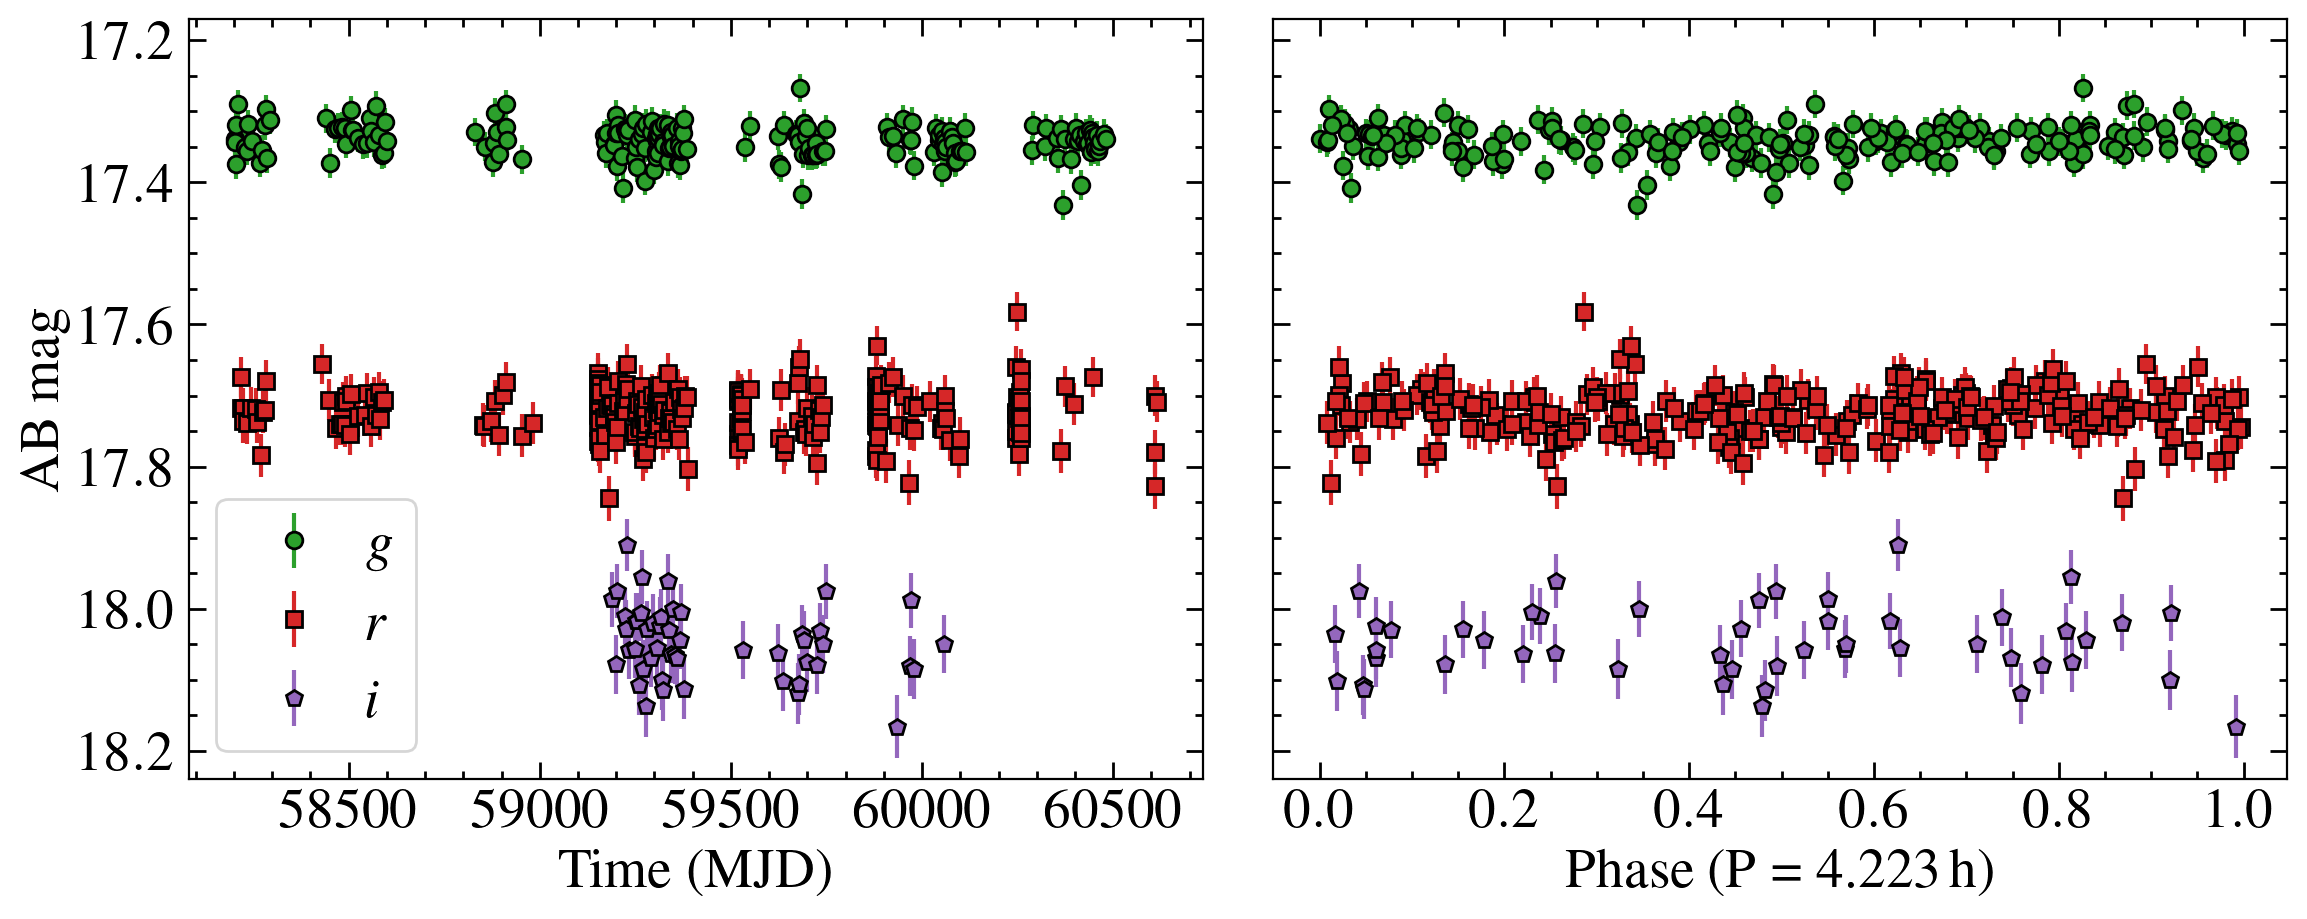

In [35]:
period_d = period.to(u.d).value

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))

t0 = min([gdata['mjd'][0], rdata['mjd'][0], idata['mjd'][1:][0]])
print(t0)

ax[0].errorbar(gdata['mjd'], gdata['mag'], yerr=gdata['magerr'], marker='o', ls='none', markeredgecolor='k', label='$g$', c='C2')
ax[0].errorbar(rdata['mjd'], rdata['mag'], yerr=rdata['magerr'], marker='s', ls='none', markeredgecolor='k', label='$r$', c='C3')
ax[0].errorbar(idata['mjd'][1:], idata['mag'][1:], yerr=idata['magerr'][1:], marker='p', ls='none', markeredgecolor='k', label = '$i$', c='C4')

ax[0].set_ylim(18.24, 17.17)
ax[0].legend(frameon=True)

ax[0].set_ylabel('AB mag')
ax[0].set_xlabel('Time (MJD)')

ax[1].errorbar(((gdata['mjd']-t0)/period_d) %1, gdata['mag'], yerr=gdata['magerr'], marker='o', ls='none', markeredgecolor='k', label='$g$', c='C2')
ax[1].errorbar(((rdata['mjd']-t0)/period_d) %1, rdata['mag'], yerr=rdata['magerr'], marker='s', ls='none', markeredgecolor='k', label='$r$', c='C3')
ax[1].errorbar(((idata['mjd'][1:]-t0)/period_d) %1, idata['mag'][1:], yerr=idata['magerr'][1:], marker='p', ls='none', markeredgecolor='k', label = '$i$', c='C4')

ax[1].set_xlabel('Phase (P = {:.4}\,h)'.format(period.value))


fig.tight_layout()

fig.savefig('plots/ztf_lcs.pdf')